In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline
import time

In [2]:
INPUT_IMAGE = 'input/Macau.jpg'
OUTPUT_PATH = 'output/result.jpg'
MODEL_PATH = 'models/Robert_D.model'
STYLE_IMAGE = 'style/StarryNight.jpg'


In [3]:
img = np.asarray(Image.open(INPUT_IMAGE).convert('RGB'), dtype=np.float32)
input_ = img.reshape((1,) + img.shape)

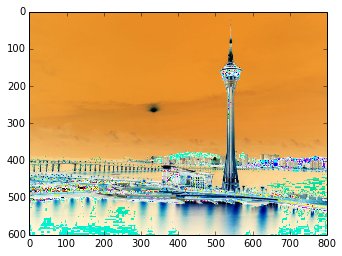

In [4]:
imshow(input_[0])

In [5]:
def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.001)
    return tf.Variable(initial, name=name)
def conv2d(x, W, strides=[1, 1, 1, 1], p='SAME', name=None):
    assert isinstance(x, tf.Tensor)
    return tf.nn.conv2d(x, W, strides=strides, padding=p, name=name)
def batch_norm(x):
    assert isinstance(x, tf.Tensor)
    mean, var = tf.nn.moments(x, axes=[1, 2, 3])
    return tf.nn.batch_normalization(x, mean, var, 0, 1, 1e-5)
def relu(x):
    assert isinstance(x, tf.Tensor)
    return tf.nn.relu(x)
def deconv2d(x, W, strides=[1, 1, 1, 1], p='SAME', name=None):
    assert isinstance(x, tf.Tensor)
    _, _, c, _ = W.get_shape().as_list()
    b, h, w, _ = x.get_shape().as_list()
    return tf.nn.conv2d_transpose(x, W, [b, strides[1]*h, strides[1]*w, c], strides=strides, padding=p, name=name)
def max_pool_2x2(x):
    assert isinstance(x, tf.Tensor)
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

class ResidualBlock():
    def __init__(self, idx, ksize=3):
        self.W1 = weight_variable([ksize, ksize, 128, 128], name='R'+str(idx)+'_conv1_w')
        self.W2 = weight_variable([ksize, ksize, 128, 128], name='R'+str(idx)+'_conv2_w')
    def __call__(self, x, idx, strides=[1, 1, 1, 1]):
        h = relu(batch_norm(conv2d(x, self.W1, strides, name='R'+str(idx)+'_conv1')))
        h = batch_norm(conv2d(h, self.W2, name='R'+ str(idx) + '_conv2'))
        return x + h

In [6]:
class FastStyleNet():
    def __init__(self):
        print('initialize transform network...')
        self.c1 = weight_variable([9, 9, 3, 32], name='t_conv1_w')
        self.c2 = weight_variable([4, 4, 32, 64], name='t_conv2_w')
        self.c3 = weight_variable([4, 4, 64, 128], name='t_conv3_w')
        self.r1 = ResidualBlock(1)
        self.r2 = ResidualBlock(2)
        self.r3 = ResidualBlock(3)
        self.r4 = ResidualBlock(4)
        self.r5 = ResidualBlock(5)
        self.d1 = weight_variable([4, 4, 64, 128], name='t_dconv1_w')
        self.d2 = weight_variable([4, 4, 32, 64], name='t_dconv2_w')
        self.d3 = weight_variable([9, 9, 3, 32], name='t_dconv3_w')

    def __call__(self, h):
        # print(h.get_shape().as_list())
        h = batch_norm(relu(conv2d(h, self.c1, name='t_conv1')))
        self.h = h
        # print(h.get_shape().as_list())
        h = batch_norm(relu(conv2d(h, self.c2, strides=[1, 2, 2, 1], name='t_conv2')))
        # print(h.get_shape().as_list())
        h = batch_norm(relu(conv2d(h, self.c3, strides=[1, 2, 2, 1], name='t_conv3')))

        # print(h.get_shape().as_list())
        h = self.r1(h, 1)
        # print(h.get_shape().as_list())
        h = self.r2(h, 2)
        # print(h.get_shape().as_list())
        h = self.r3(h, 3)
        # print(h.get_shape().as_list())
        h = self.r4(h, 4)
        # print(h.get_shape().as_list())
        h = self.r5(h, 5)

        # print(h.get_shape().as_list())
        h = batch_norm(relu(deconv2d(h, self.d1, strides=[1, 2, 2, 1], name='t_deconv1')))
        # print(h.get_shape().as_list())
        h = batch_norm(relu(deconv2d(h, self.d2, strides=[1, 2, 2, 1], name='t_deconv2')))
        # print(h.get_shape().as_list())
        y = deconv2d(h, self.d3, name='t_deconv3')
        # print(y.get_shape().as_list())
        return tf.multiply((tf.tanh(y) + 1), tf.constant(127.5, tf.float32, shape=y.get_shape()), name='output')

In [7]:
with tf.device("/cpu:0"):
    transform = FastStyleNet()
    image =  tf.placeholder(tf.float32, [1, input_.shape[1], input_.shape[2], 3])
    output = transform(image)
    saver = tf.train.Saver()
s_time = time.time()

initialize transform network...


In [8]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    saver.restore(sess, MODEL_PATH)
    print("Model restored.")
    out = sess.run(output, feed_dict={image: input_})


Model restored.


In [9]:
print('time: {} sec'.format(time.time() - s_time))
out = out.reshape((out.shape[1:]))
im = Image.fromarray(np.uint8(out))
im.save(OUTPUT_PATH)

time: 3.89563894272 sec
